In [19]:
import numpy as np
import pandas as pd
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis
import matplotlib.pyplot as plt
import fklab.signals.multitaper as mt
import scipy.signal
import fklab.signals.filter

%matplotlib notebook

plt.style.use('seaborn-ticks')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import itertools

from fklab.io.data import import_position
from fklab.io.data import import_environment
import fklab.geometry.utilities
import fklab.segments as segments
from fklab.segments import Segment

from fklab.signals.smooth import kernelsmoothing
from fklab.behavior import task_analysis

from data_analysis import loading

loading.load_project('/media/kasia/K/Neuropixeldata/LS_k_5/12032020_g0/catgt_12032020_g0')
loading.load_lfp('12032020_g0_t0.imec0.lf.bin')


In [23]:
loading.load_cluster()
ls_data = loading.cluster_data
loading.load_position('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-12_11-14-14/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-12_11-14-14/Events.nev',)

In [25]:
from data_analysis import time_synchro

time_shift = time_synchro.synchro(
    '/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-12_11-14-14/Events.nev', 
    loading.lfp_data_path,
)

time_shift

mean -6.608683351495725
std 0.00015643284295745343


-6.608683351495725

In [27]:
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift
corrected_time

array([2221.40331365, 2221.44288865, 2221.48345065, ..., 4683.30672265,
       4683.34631665, 4683.38644265])

In [28]:
#here we access the keys of the dictionary position_yaml
epoch = loading.position_yaml['source']['epoch']
epoch
open_box_epoch = [2861, 4699]
# linear_track_epoch = [13883, 14456]

# sleep_box_epoch = [14502, 15686]


In [29]:
from fklab.geometry.shapes import rectangle
open_box_data = loading.environment_yaml['open_field']['shapes']['open_field']['shape']
open_box = rectangle(**open_box_data)
open_box


rectangle (size=[257.8875,271.11249999999995], center=[380.2187499999999,168.61874999999998], orientation=0.0 rad)

In [30]:
from fklab.plot.core.interaction import Rectangle

open_box_i = Rectangle(open_box.center, *open_box.size, open_box.orientation, fill=False, color='r')

# plt.gca().add_artist(open_box_i)
# plt.xlim(200, 700)
# plt.ylim(150, 500)

# open_box_i.xy


In [104]:
from  fklab.geometry.shapes import polyline

linear_track_data = loading.environment_yaml['linear_track']['shapes']['linear_track']['shape']['polylines'][0]
linear_track = polyline(**linear_track_data)
linear_track


straight polyline with 2 vertices

In [105]:
from fklab.plot.core.interaction import iPolyline
linear_track_i = iPolyline(linear_track.vertices, color='k')
# plt.gca().add_artist(linear_track_i)
# plt.xlim(200, 600)
# plt.ylim(350, 500)
print(linear_track.vertices)

[[219. 422.]
 [520. 419.]]


<IPython.core.display.Javascript object>


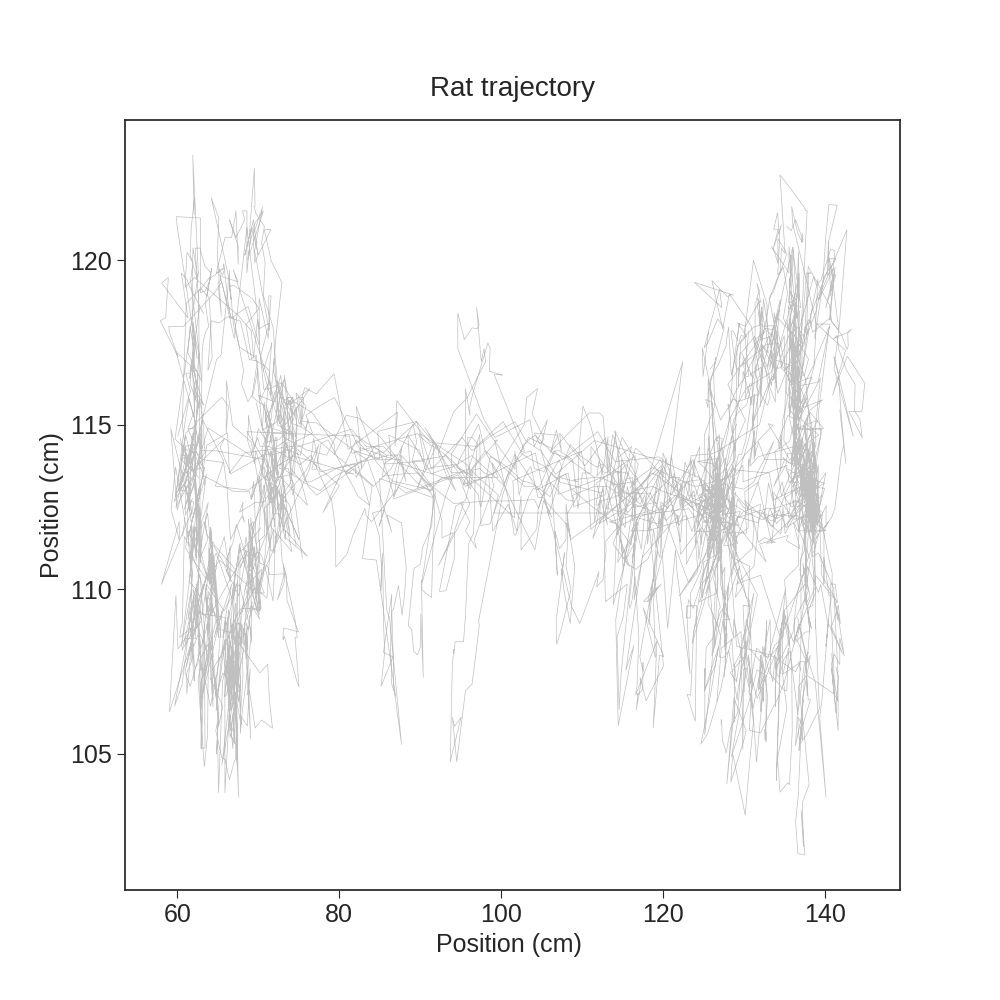

In [261]:
position_lt = loading.position[np.logical_and(corrected_time > linear_track_epoch[0],
                                      corrected_time < linear_track_epoch[1]), :]
position_lt_cm = position_lt* 0.27


# plt.savefig('lt_trajectory2911.png')



_, points, *_ = fklab.geometry.utilities.point2polyline(linear_track.vertices, position_lt, clip=('normal', 'normal'))

plt.plot(position_lt_cm[:, 0], position_lt_cm[:, 1], color='silver', lw=0.5)
# plt.xlim(100, 600)
# plt.ylim(400, 500)

# position_ob = loading.position[np.logical_and(corrected_time > open_box_epoch[0],
#                                       corrected_time < open_box_epoch[1]), :]
# position_ob_cm = position_ob * 0.27

# plt.plot(position_ob_cm[:, 0], position_ob_cm[:, 1], color='silver', lw=0.5)
# plt.xlim(60, 140)
# plt.ylim(20, 100)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory", y=1.02)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.savefig("rat_trajectory (open box).png")


<IPython.core.display.Javascript object>


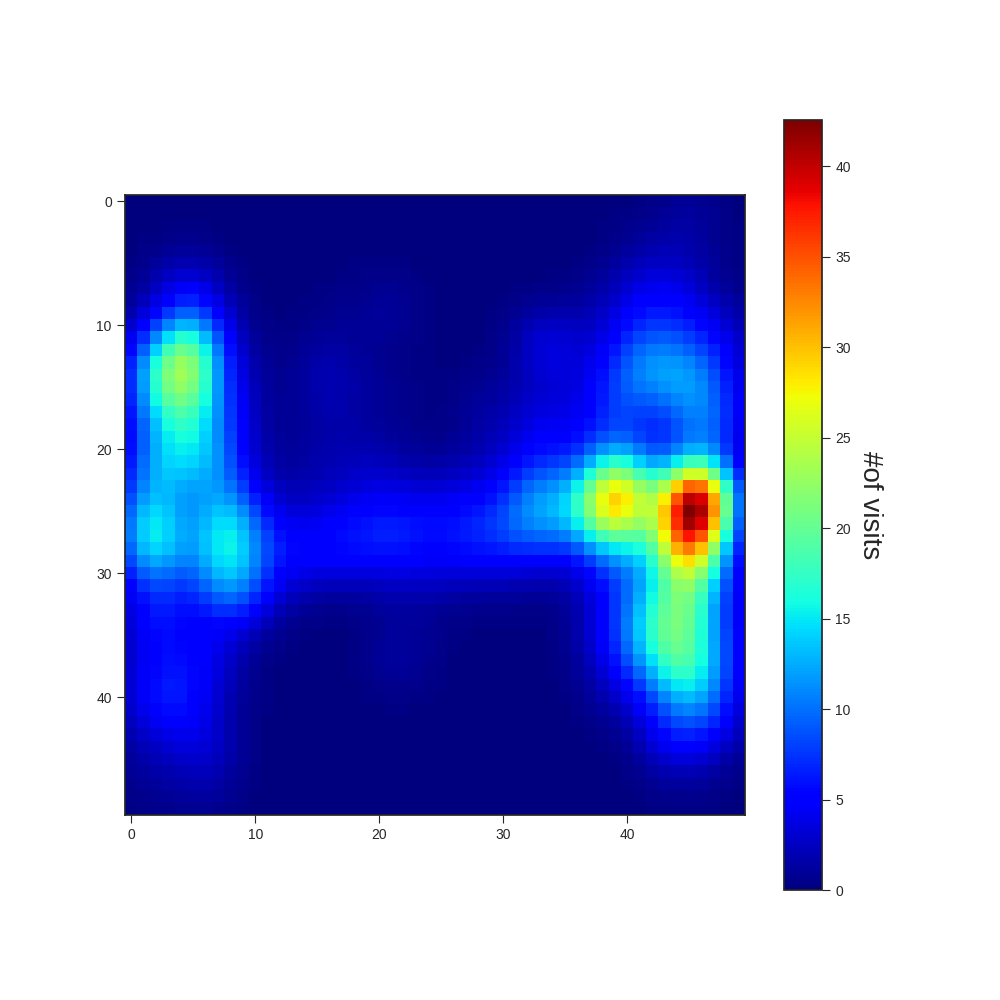

In [107]:
#load spike times from the kilosort data within particular epoch
from scipy.stats import binned_statistic_2d

plt.rcParams["figure.figsize"] = (10,10)

spike_time_range = np.array(linear_track_epoch)  + time_shift
# print(spike_time_range)

# for cluster_index, cluster_id in enumerate(ls_data['id']):
# #     print('cluster_id', cluster_id)
    
#     spike_ts = loading.ks_spike_times[np.logical_and.reduce((
#         loading.ks_spike_clusters == cluster_id,
#         spike_time_range[0] <= loading.ks_spike_times[:, 0],
#         loading.ks_spike_times[:, 0] <= spike_time_range[1]
#     )), 0]
        
#     spike_t.extend(spike_ts)

# spike_x = loading.get_spike_seq(spike_time_range, channel_list=[365])
# spike_t = loading.ks_spike_times[spike_x, 0]
# #spike count
# spike_count = len(spike_t)


x = position_lt[:, 0]
y = position_lt[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

pos_bin = scipy.stats.binned_statistic_2d(x[mask], 
                                          y[mask], 
                                          np.ones_like(x), 
                                          statistic='count', 
                                          bins=50)[0]

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([2,2]) )
S = smooth.Smoother(K)
pos_bin_smoothed = S(pos_bin)

plt.imshow(pos_bin_smoothed.T, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('#of visits', rotation=270, fontsize=20, verticalalignment="bottom")
plt.savefig('occupancy_map_2911_linear_track.png')


binned = scipy.stats.binned_statistic(spike_t, np.ones_like(spike_t), 
                                               statistic='count',
                                               bins=(spike_time_range[1] - spike_time_range[0]), 
                                               range=None)[0]




In [ ]:
len(spike_t)

<IPython.core.display.Javascript object>


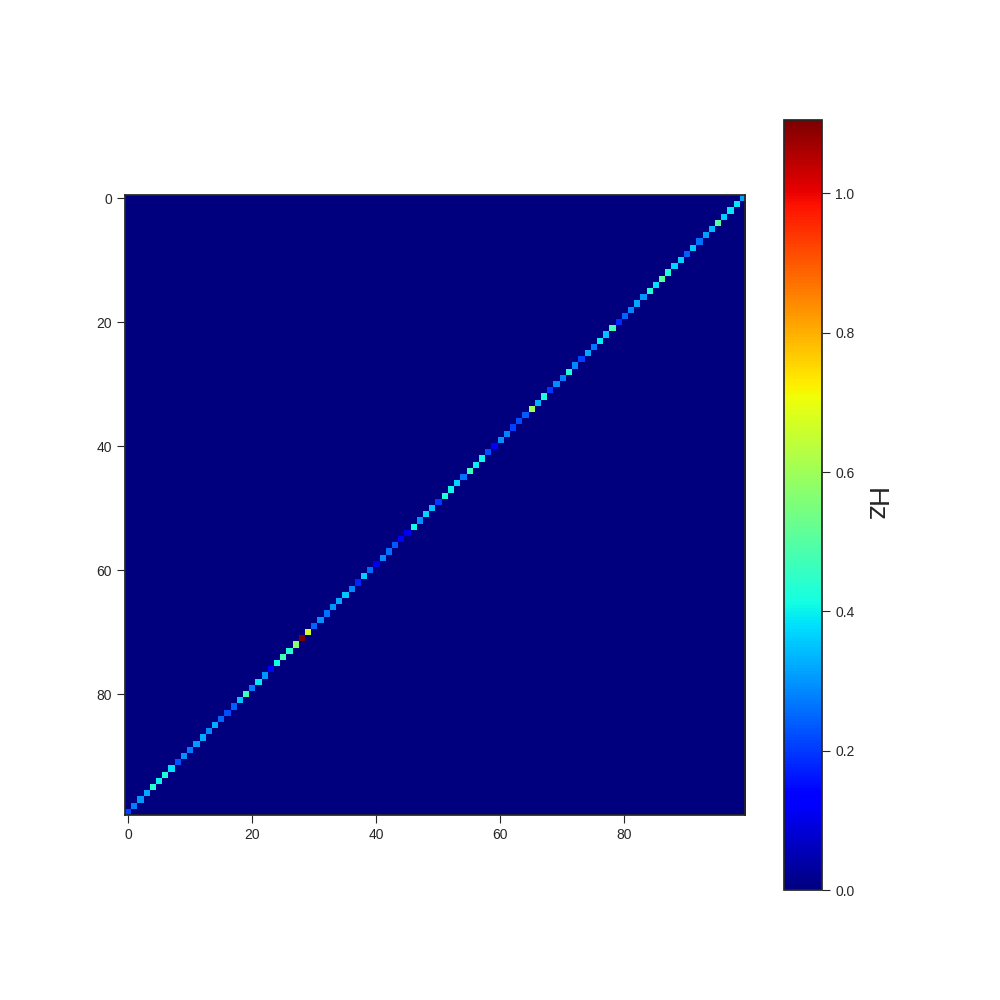

Text(0, 0.5, 'Hz')

In [108]:
#linear track
spike_t = []
spike_time_range = np.array(linear_track_epoch) - linear_track_epoch[0] + time_shift
# print(spike_time_range)
picked_channel = [325]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(ls_data['id']):
#     print('cluster_id', cluster_id)
    if ls_data['channel'][cluster_index] not in picked_channel:
        continue
        
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cluster_id,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

    
# print(len(spike_t))


x = points[:, 0]
y = points[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=100)[0]
# print(spike_bin)
# plt.plot(x[mask], spike_bin)
spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

# print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

# #create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)

plt.imshow(spike_bin, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
# # plt.savefig('firingrate_2911_linear_track365.png')


<IPython.core.display.Javascript object>


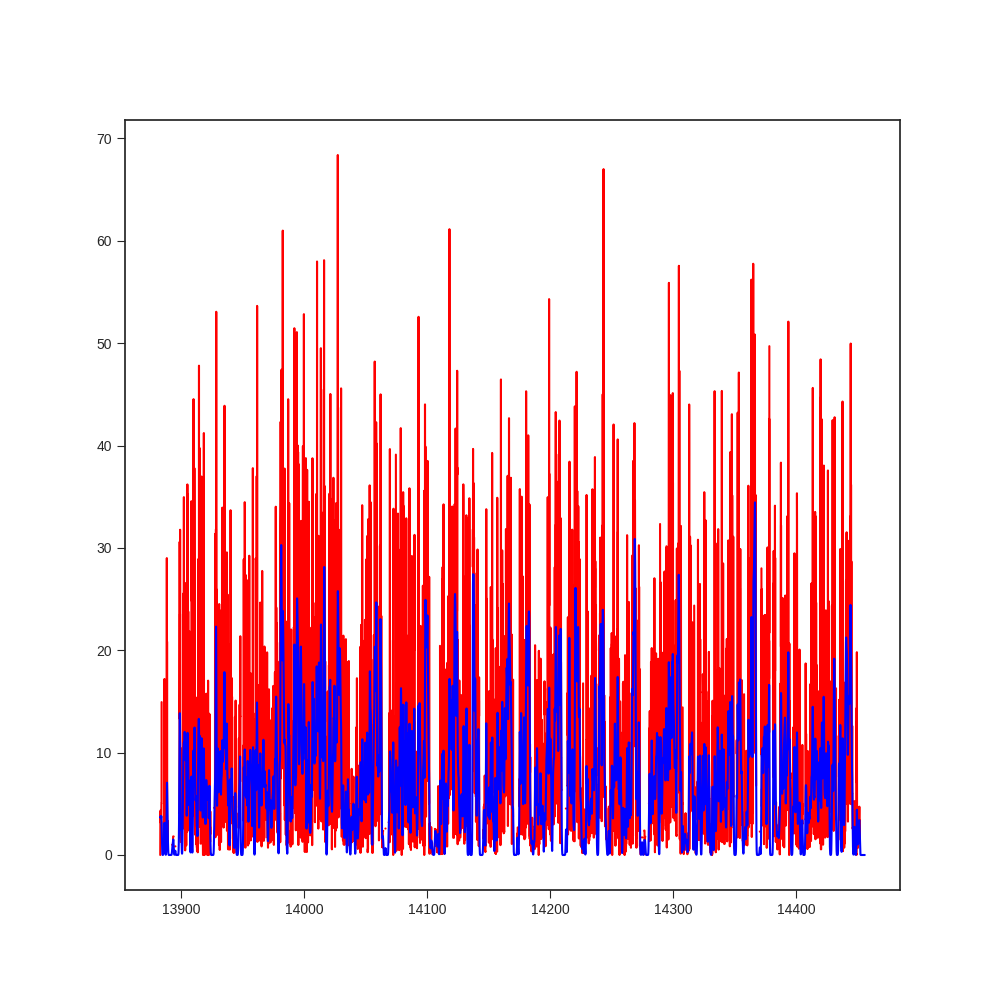

In [109]:
mask_lt = np.logical_and(corrected_time > linear_track_epoch[0],
                                      corrected_time < linear_track_epoch[1])
position_lt = loading.position[mask_lt, :]
position_lt
linear_track_epoch
x = position_lt[:, 0]
y = position_lt[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

dx = np.diff(x)
dy = np.diff(y)
distance = np.sqrt(dx**2 + dy**2)
speed = distance / np.diff(corrected_time[mask_lt])   

d = np.zeros((len(x), 2))
vellt = np.zeros_like(d)
time_v = np.zeros_like(x)
vel_vlt = np.zeros_like(x)
pixel = 0.27

for i in range(1, len(position_lt)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    time_v[i] = corrected_time[mask_lt][i+1] - corrected_time[mask_lt][i-1]
    vellt[i, :] = abs((d[i] / time_v[i]) * pixel)
    vel_vlt[i] = np.sqrt(vellt[i,0]**2 + vellt[i, 1]**2)


plt.plot(corrected_time[mask_lt], vel_vlt, color='r')

# run = vel_v[vel_v > 5 ]
# plt.plot(run)
# plt.plot(vel_v, color='r')

run = vel_v[vel_v > 5 ]

vel_vlt[np.isnan(vel_vlt)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothedlt = S(vel_vlt)
vel_smoothedlt

plt.plot(corrected_time[mask_lt], vel_smoothedlt, color='b')


<IPython.core.display.Javascript object>


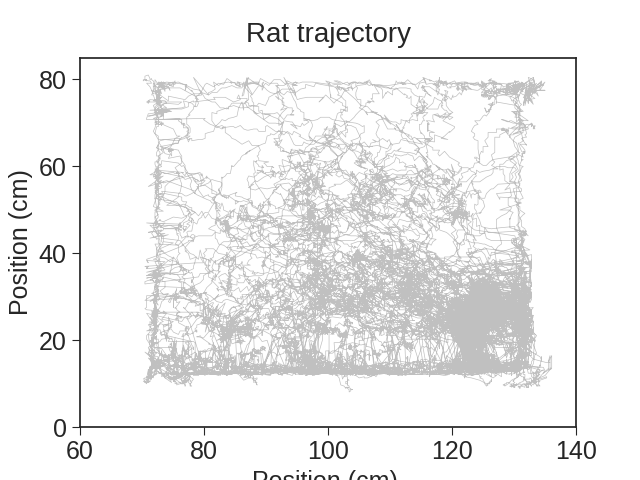

In [31]:
position_ob = loading.position[np.logical_and(corrected_time > open_box_epoch[0],
                                      corrected_time < open_box_epoch[1]), :]
position_ob_cm = position_ob * 0.27

plt.plot(position_ob_cm[:, 0], position_ob_cm[:, 1], color='silver', lw=0.5)
plt.xlim(60, 140)
plt.ylim(0, 85)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory", y=1.02)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.savefig("rat_trajectory (open box).png")


<IPython.core.display.Javascript object>


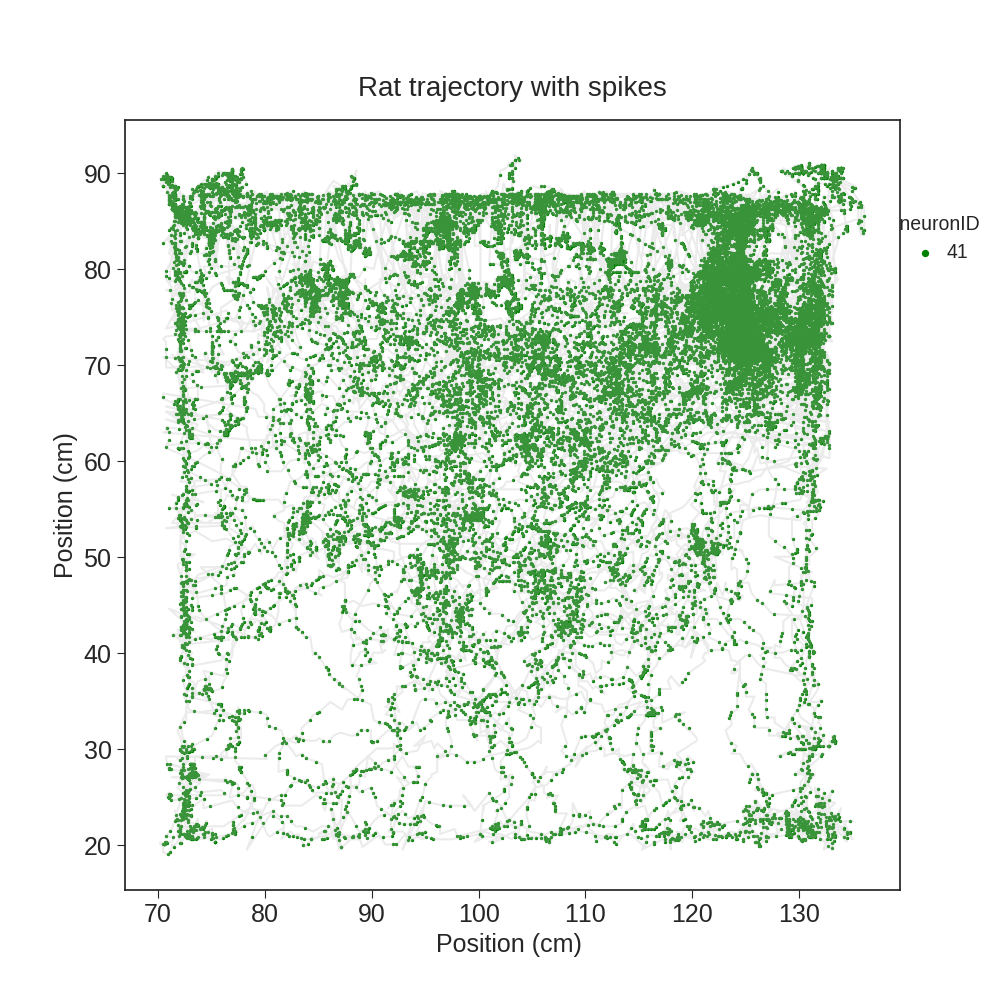

In [38]:
from scipy.interpolate import interp1d

spike_time_range = np.array(open_box_epoch) - loading.evt_start_time + time_shift
# spike_time_range = np.array(linear_track_epoch) - loading.evt_start_time + time_shift

plt.rcParams["figure.figsize"] = (10,10)

ks_spike_times = loading.ks_spike_times[:, 0]
spike_t_305 = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=[305])]  + loading.evt_start_time
spike_t_41 = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=[41])]  + loading.evt_start_time

# # spike_t = spike_t_340
# print('len(spike_t)=', len(spike_t))
# print('spike_t.min, max=', spike_t.min(0), spike_t.max(0))


t_ob = corrected_time[np.logical_and(corrected_time > open_box_epoch[0], corrected_time < open_box_epoch[1])]
# t_lt = corrected_time[np.logical_and(corrected_time > linear_track_epoch[0], corrected_time < linear_track_epoch[1])]
mask = ~np.logical_or.reduce((
    np.isnan(t_ob),
    np.isnan(position_ob_cm[:, 0]),
    np.isnan(position_ob_cm[:, 1]),
))
# mask = ~np.logical_or.reduce((
#     np.isnan(t_lt),
#     np.isnan(position_lt_cm[:, 0]),
#     np.isnan(position_lt_cm[:, 1]),
# ))

# print('   t_ob.min, max=', t_ob[mask].min(), t_ob[mask].max())
plt.plot(position_ob_cm[mask, 0], 100 - position_ob_cm[mask, 1], color="silver", alpha=0.3)
# plt.plot(position_lt_cm[mask, 0], position_lt_cm[mask, 1], color="silver", alpha=0.3)

interp1d_od = interp1d(t_ob[mask], position_ob_cm[mask, :],
                      axis=0, 
#                     fill_value='extrapolate', 
                    bounds_error=False,
                    assume_sorted=True)
# interp1d_od = interp1d(t_lt[mask], position_lt_cm[mask, :],
#                       axis=0, 
# #                     fill_value='extrapolate', 
#                     bounds_error=False,
#                     assume_sorted=True)


spike_xy_305 = interp1d_od(spike_t_305)
spike_xy_41 = interp1d_od(spike_t_41)


# plt.scatter(spike_xy_365[:, 0], spike_xy_365[:, 1], s=2, color='r', label='365')
plt.scatter(spike_xy_41[:, 0], 100 - spike_xy_41[:, 1], s=2, color='g', label='41')

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory with spikes", y=1.02)
plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.savefig("rat_trajectory (open field)41.png")

plt.show()

In [230]:
# hole on previous
channel_list = [338]
spike_t_tmp = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=channel_list)]  + loading.evt_start_time
spike_xy_tmp = interp1d_od(spike_t_tmp)
plt.scatter(spike_xy_tmp[:, 0], spike_xy_tmp[:, 1], s=2, color='b')


41421


<IPython.core.display.Javascript object>


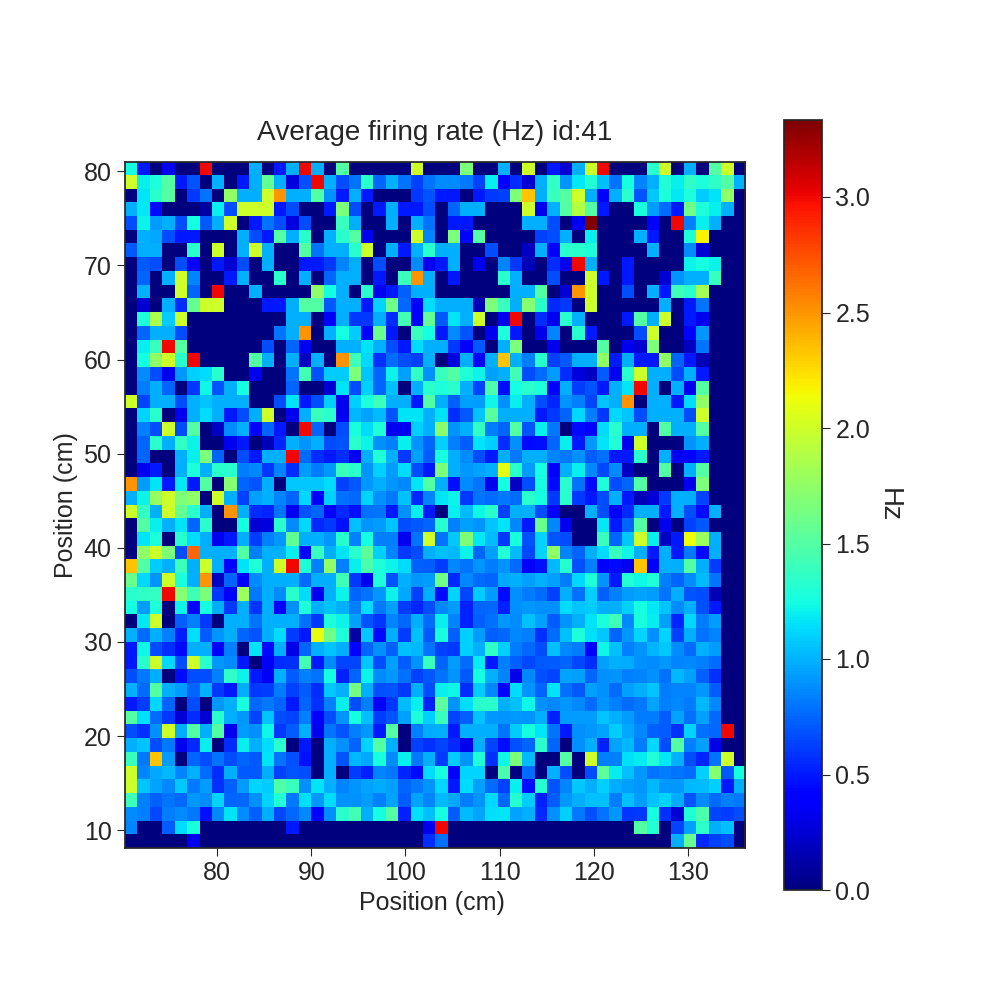

In [41]:
#open box
spike_t = []
spike_time_range = np.array(open_box_epoch) - open_box_epoch[0] + time_shift
# print(spike_time_range)
picked_channel = [41]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(ls_data['id']):
#     print('cluster_id', cluster_id)
    if ls_data['channel'][cluster_index] not in picked_channel:
        continue
        
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cluster_id,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

    
print(len(spike_t))


x = position_ob_cm[:, 0]
y = position_ob_cm[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=50)[0]

spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

# print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)
extent = (
    np.min(x[mask]), np.max(x[mask]),
    np.min(y[mask]), np.max(y[mask])
)


plt.imshow(spike_bin, cmap='jet', origin='lower', extent=extent)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Average firing rate (Hz) id:41", y=1.02)
# plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.savefig("firing_rate(open field)41.png")
plt.show()


<IPython.core.display.Javascript object>


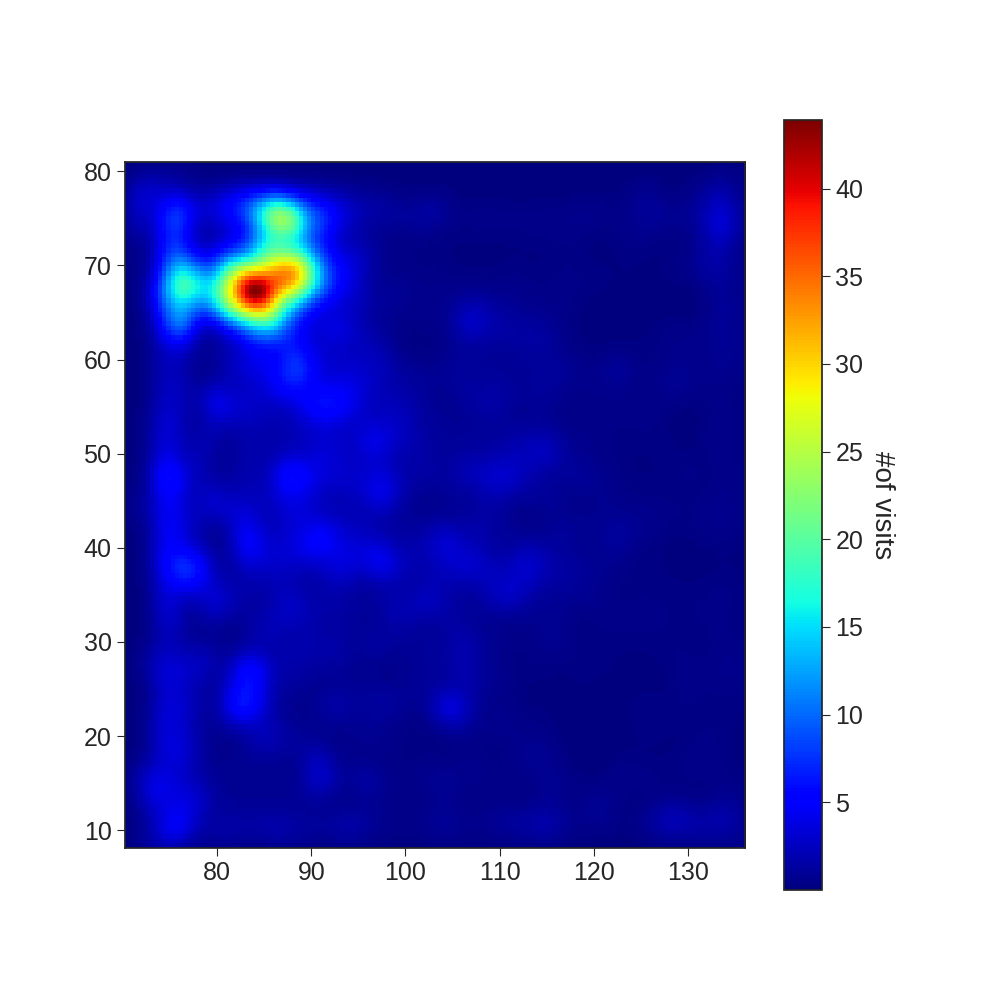

In [45]:
from scipy.stats import binned_statistic_2d

x = position_ob_cm[:, 0]
y = position_ob_cm[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

pos_bin = scipy.stats.binned_statistic_2d(x[mask], 
                                          y[mask], 
                                          np.ones_like(x), 
                                          statistic='count', 
                                          bins=150)[0]

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K)
pos_bin_smoothed = S(pos_bin)

extent = (
    np.min(x[mask]), np.max(x[mask]),
    np.min(y[mask]), np.max(y[mask])
)

plt.imshow(pos_bin_smoothed, cmap='jet', origin='lower', extent=extent)
cbar = plt.colorbar()
cbar.ax.set_ylabel('#of visits', rotation=270, fontsize=20, verticalalignment="bottom")
plt.savefig('occupancy_map_1203_openfield.png')


In [134]:
#open box
spike_t = []
spike_time_range = np.array(open_box_epoch) - open_box_epoch[0] + time_shift
# print(spike_time_range)
# picked_channel = [382]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(ls_data['id']):
#     print('cluster_id', cluster_id)
    if ls_data['channel'][cluster_index] not in picked_channel:
        continue
        
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cluster_id,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

    
# print(len(spike_t))


x = position_ob[:, 0]
y = position_ob[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

# spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
#                                             x[mask], 
#                                             spike_times_binned[mask], 
#                                             statistic='mean', 
#                                             bins=50)[0]
spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='sum', 
                                            bins=50)[0]

spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

# #create kernel
# K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
# S = smooth.Smoother(K, unbiased=True)
# spike_bin_smoothed = S(spike_bin)

plt.imshow(spike_bin, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
# plt.savefig('firingrate_2911_open_boxch382.png')


0.0 254.0


Text(0, 0.5, 'Hz')

<IPython.core.display.Javascript object>


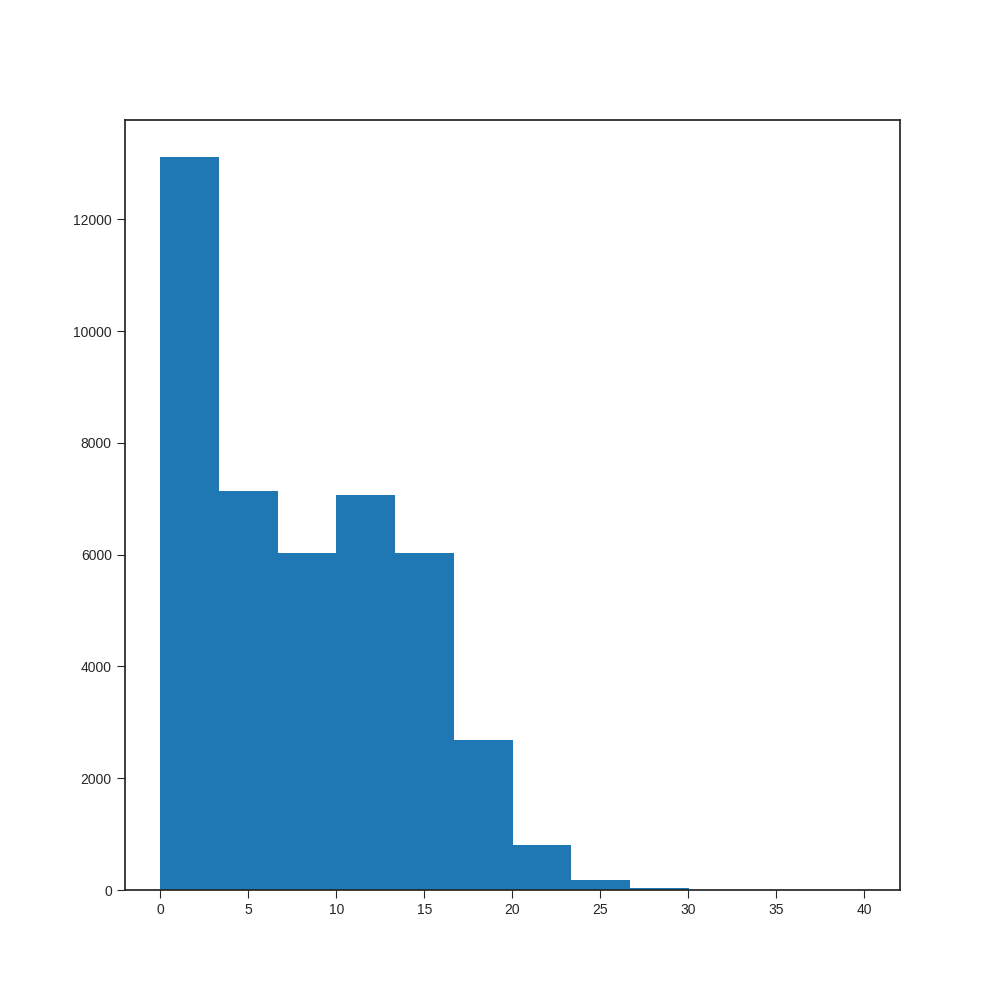

[1.3124e+04 7.1320e+03 6.0250e+03 7.0620e+03 6.0340e+03 2.6790e+03
 8.0300e+02 1.8700e+02 3.5000e+01 7.0000e+00 3.0000e+00 6.0000e+00]


In [68]:
mask_ob = np.logical_and(corrected_time > open_box_epoch[0],
                                      corrected_time < open_box_epoch[1])
position_ob = loading.position[mask_ob, :]
position_ob

x = position_ob[:, 0]
y = position_ob[:, 1]
corrected_time_ob = corrected_time[mask_ob]

dx = np.diff(x)
dy = np.diff(y)
distance = np.sqrt(dx**2 + dy**2)
speed = distance / np.diff(corrected_time[mask_ob])   

d = np.zeros((len(x), 2))
vel = np.zeros_like(d)
time_v = np.zeros_like(x)
vel_v = np.zeros_like(x)
pixel = 0.27

for i in range(1, len(position_ob)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    time_v[i] = corrected_time_ob[i+1] - corrected_time_ob[i-1]
    vel[i, :] = abs((d[i] / time_v[i]) * pixel)
    vel_v[i] = np.sqrt(vel[i,0]**2 + vel[i, 1]**2)


# plt.plot(corrected_time_ob, vel_v, color='r')

# run = vel_smoothed[vel_smoothed > 5 ]
# plt.plot(run)
vel_v[np.isnan(vel_v)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothed = S(vel_v)
vel_smoothed


# plt.plot(corrected_time_ob, vel_smoothed, color='b')

# plt.plot(corrected_time_ob, d[:, 0])
# plt.plot(corrected_time_ob, d[:, 1])


# # plt.plot(vel_n, color='k')
# plt.plot(vel_smoothed, color='r')
# plt.imshow(vel_smoothed, cmap='jet')
# # cbar = plt.colorbar()
# # cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
# # # plt.savefig('firingrate_2911_open_box.png')


# nonnan_mask = ~np.logical_or(np.isnan(x), np.isnan(y))
# vel_bin = scipy.stats.binned_statistic(vel_smoothed,  
#                                        np.ones_like(vel_smoothed), 
#                                        statistic='count', 
#                                        bins=20)[0]
# plt.plot(vel_bin)
n, bins, _ = plt.hist(vel_smoothed, bins=12)
print(n)

# plt.imshow(vel_bin, cmap='gnuplot')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('cm/s', rotation=270, fontsize=20, verticalalignment="bottom")


In [85]:
len(n)

12

<IPython.core.display.Javascript object>


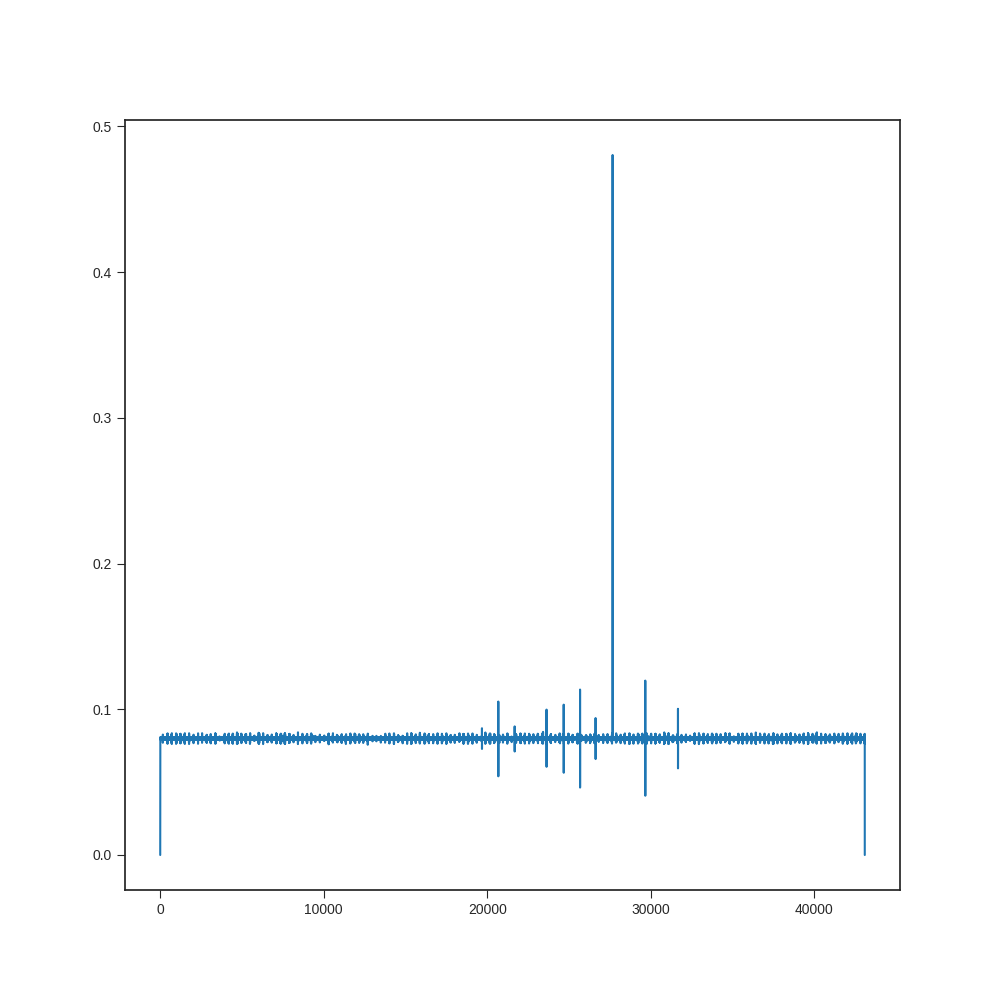

In [69]:
vel_we_want = np.logical_and.reduce((
    vel_smoothed >= 1,
    vel_smoothed <= 5,
    ~np.isnan(x),
    ~np.isnan(y),
))

vel_bin_1 = scipy.stats.binned_statistic_2d(x[vel_we_want],
                                            y[vel_we_want],
                                            np.ones_like(x[vel_we_want]),
                                            statistic='sum', 
                                            bins=20)[0]
# plt.imshow(vel_bin_1)

vel_we_want = np.logical_and.reduce((
    vel_smoothed >= 1,
    vel_smoothed <= 5,
    ~np.isnan(x),
    ~np.isnan(y),
))

vel_bin_1 = scipy.stats.binned_statistic_2d(x[vel_we_want],
                                            y[vel_we_want],
                                            time_v[vel_we_want],
                                            statistic='sum', 
                                            bins=20)[0]
# plt.imshow(vel_bin_1)
plt.plot(time_v)

speedvstime = []

for v_seg in range(0, int(max(vel_smoothed)), 5):
    _v_x = np.logical_and.reduce((
        vel_smoothed >= v_seg,
        vel_smoothed <= v_seg + 5,
        ~np.isnan(x),
        ~np.isnan(y),
    ))
    
    _v_bin = scipy.stats.binned_statistic_2d(x[_v_x],
                                            y[_v_x],
                                            np.ones_like(x[_v_x]),
                                            statistic='count', 
                                            bins=20)[0]
    
    _t_bin = scipy.stats.binned_statistic_2d(x[_v_x],
                                            y[_v_x],
                                            time_v[_v_x],
                                            statistic='sum', 
                                            bins=20)[0]
    
    _s_bin = 0
    
    speedvstime.append((_v_bin, _t_bin, _s_bin))



In [82]:
vel_we_want

array([False, False, False, ..., False, False, False])

In [70]:
loading.get_spike_seq([15, 25], channel_list=[340])
# loading.ks_spike_times

array([False, False, False, ..., False, False, False])

In [ ]:
for i in corrected_time

In [71]:
x = position_ob[:, 0]
y = position_ob[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

# vel_spike[np.isnan(vel_spike)] = 0.0
# vel_spike[np.isinf(vel_spike)] = 0.0


    

In [22]:
# pos_x = points[:, 0]
# pos_m =[]
# pos_b = np.zeros(pos_x.shape)
# i=0
# bin_number=0
# while i < len(pos_x)-1:
#     b=1
#     while (abs(pos_x[i+b] - pos_x[i])) < 20:
#         b +=1
#     print(abs(pos_x[i+b] - pos_x[i]))
#     pos_b[i:i+b]= bin_number
#     print(pos_b[i:i+b])
#     bin_number +=1
#     i +=b

    



In [147]:
# plt.plot(range(0, len(pos_x)), pos_b)
# print(pos_b)
# plt.plot(pos_x)

<IPython.core.display.Javascript object>


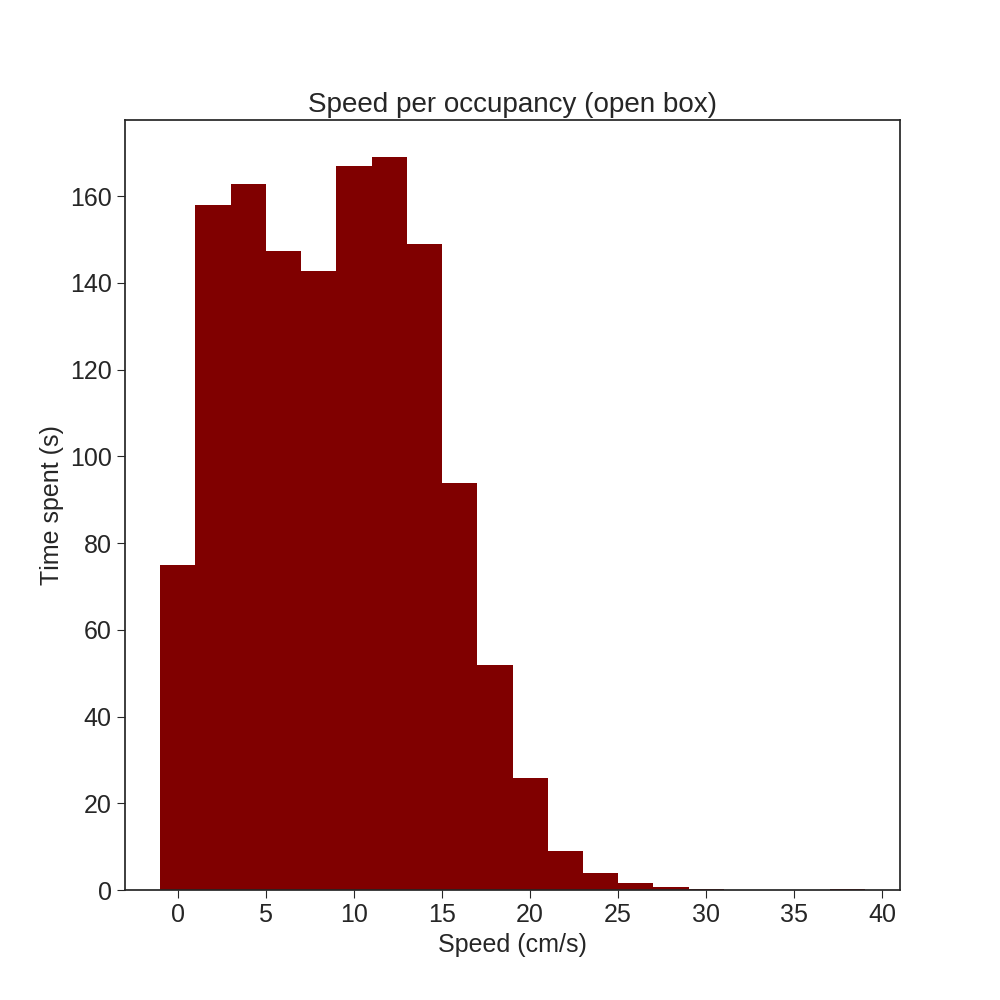

In [243]:
mask_ob = np.logical_and(corrected_time > open_box_epoch[0],
                                      corrected_time < open_box_epoch[1])
position_ob = loading.position[mask_ob, :]
position_ob

x = position_ob[:, 0]
y = position_ob[:, 1]
corrected_time_ob = corrected_time[mask_ob]

dx = np.diff(x)
dy = np.diff(y)
distance = np.sqrt(dx**2 + dy**2)
speed = distance / np.diff(corrected_time[mask_ob])   

d = np.zeros((len(x), 2))
vel = np.zeros_like(d)
time_v = np.zeros_like(x)
vel_v = np.zeros_like(x)
pixel = 0.27

for i in range(1, len(position_ob)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    time_v[i] = corrected_time_ob[i+1] - corrected_time_ob[i-1]
    vel[i, :] = abs((d[i] / time_v[i]) * pixel)
    vel_v[i] = np.sqrt(vel[i,0]**2 + vel[i, 1]**2)


# plt.plot(corrected_time_ob, vel_v, color='r')

# run = vel_smoothed[vel_smoothed > 5 ]
# plt.plot(run)
vel_v[np.isnan(vel_v)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothed = S(vel_v)
vel_smoothed


def time_spent(vel_range, picked_cluster = None):
    
    idx = np.logical_and.reduce((
        vel_smoothed >= vel_range[0],
        vel_smoothed <= vel_range[1],
        ~np.isnan(x),
        ~np.isnan(y),
    ))

    dt = np.diff(corrected_time_ob, prepend=corrected_time_ob[0])
   
    if picked_cluster is None:
        cluster_x = slice(None, None)
    else:
        if len(picked_cluster) == 0:
            raise RuntimeError('empty picked_cluster')
            
        cluster_x = np.logical_or.reduce(tuple(
            loading.ks_spike_clusters == cluster
            for cluster in picked_cluster
        ))
    
    ks_spike_times = loading.ks_spike_times[cluster_x, 0] + loading.evt_start_time
    
    spike_x = scipy.stats.binned_statistic(ks_spike_times,
                                              values=np.ones_like(ks_spike_times),
                                              statistic='count',
                                              bins=corrected_time_ob)[0]
#     print(spike_x)
    spike_count = np.sum(spike_x[idx[:-1]])
    
    return np.sum(dt[idx]), spike_count

vel_bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
dt_value = np.array([
    time_spent(v_range)
    for v_range in zip(vel_bins,vel_bins[1:])
])
# dt_value_357 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([357, 365]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
# dt_value_323 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([323]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])


sum(dt_value)
# print(dt_value)
plt.bar(np.array(vel_bins[:-1]), dt_value[:, 0], width=2, color='maroon')
# plt.bar(np.array(vel_bins[:-1]), dt_value_323[:, 1], width=2, color='limegreen', alpha=0.5)
# plt.bar(np.array(vel_bins[:-1]), dt_value_357[:, 1], width=2, color='forestgreen')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Time spent (s)")
plt.title("Speed per occupancy (open box)")
plt.savefig("Speed per occupancy (open box).png")
plt.show()

In [81]:
ks_spike_times = loading.ks_spike_times[:, 0] + loading.evt_start_time / 1e6
print(ks_spike_times)
print(corrected_time)

[1.62439105e-02 1.70439105e-02 1.70439105e-02 ... 3.67358074e+03
 3.67358478e+03 3.67358711e+03]
[12103.76882074 12103.80838074 12103.84896074 ... 14473.63280074
 14473.67309774 14473.71245774]


<IPython.core.display.Javascript object>


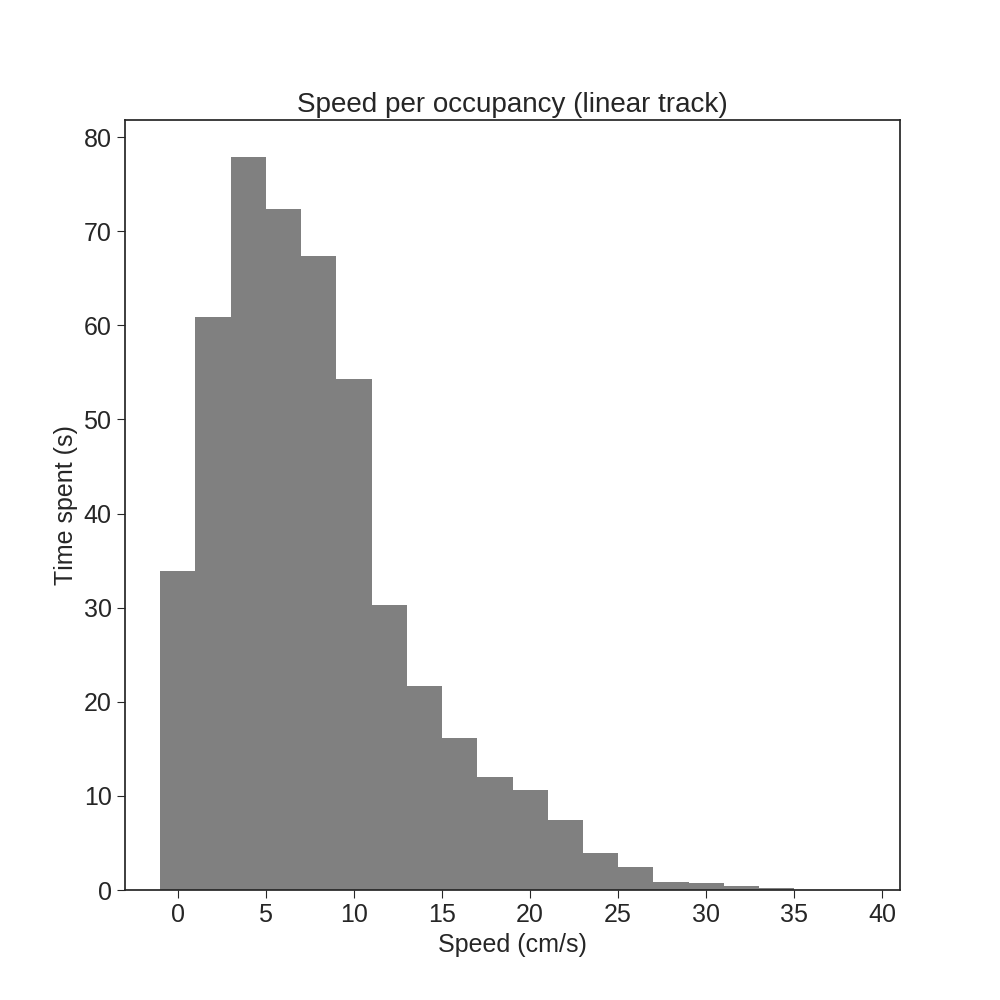

In [244]:
mask_lt = np.logical_and(corrected_time > linear_track_epoch[0],
                                      corrected_time < linear_track_epoch[1])
position_lt = loading.position[mask_lt, :]
position_lt

x = position_lt[:, 0]
y = position_lt[:, 1]
corrected_time_lt = corrected_time[mask_lt]

d = np.zeros((len(x), 2))
vel = np.zeros_like(d)
time_v = np.zeros_like(x)
vel_v = np.zeros_like(x)
pixel = 0.27

for i in range(1, len(position_lt)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    time_v[i] = corrected_time_lt[i+1] - corrected_time_lt[i-1]
    vel[i, :] = abs((d[i] / time_v[i]) * pixel)
    vel_v[i] = np.sqrt(vel[i,0]**2 + vel[i, 1]**2)


# plt.plot(corrected_time_ob, vel_v, color='r')

# run = vel_smoothed[vel_smoothed > 5 ]
# plt.plot(run)
vel_v[np.isnan(vel_v)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothed = S(vel_v)
vel_smoothed


def time_spent(vel_range, picked_cluster = None):
    
    idx = np.logical_and.reduce((
        vel_smoothed >= vel_range[0],
        vel_smoothed <= vel_range[1],
        ~np.isnan(x),
        ~np.isnan(y),
    ))

    dt = np.diff(corrected_time_lt, prepend=corrected_time_lt[0])
   
    if picked_cluster is None:
        cluster_x = slice(None, None)
    else:
        if len(picked_cluster) == 0:
            raise RuntimeError('empty picked_cluster')
            
        cluster_x = np.logical_or.reduce(tuple(
            loading.ks_spike_clusters == cluster
            for cluster in picked_cluster
        ))
    
    ks_spike_times = loading.ks_spike_times[cluster_x, 0] + loading.evt_start_time
    
    spike_x = scipy.stats.binned_statistic(ks_spike_times,
                                              values=np.ones_like(ks_spike_times),
                                              statistic='count',
                                              bins=corrected_time_lt)[0]
#     print(spike_x)
    spike_count = np.sum(spike_x[idx[:-1]])
    
    return np.sum(dt[idx]), spike_count

vel_bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
dt_value = np.array([
    time_spent(v_range)
    for v_range in zip(vel_bins,vel_bins[1:])
])
# dt_value_357 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([361]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
# dt_value_361 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([361]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])

sum(dt_value)
# print(dt_value)
plt.bar(np.array(vel_bins[:-1]), dt_value[:, 0], width=2, color='grey')
# plt.bar(np.array(vel_bins[:-1]), dt_value_361[:, 1], width=2, color='fuchsia')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Time spent (s)")
plt.title("Speed per occupancy (linear track)")
plt.savefig("Speed per occupancy (linear  track).png")

In [271]:
mask_lt = np.logical_and(corrected_time > linear_track_epoch[0],
                                      corrected_time < linear_track_epoch[1])
position_lt = loading.position[mask_lt, :]
position_lt

x = position_lt[:, 0]
y = position_lt[:, 1]
corrected_time_lt = corrected_time[mask_lt]

d = np.zeros((len(x), 2))
vel = np.zeros_like(d)
time_v = np.zeros_like(x)
vel_v = np.zeros_like(x)
pixel = 0.27

for i in range(1, len(position_lt)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    time_v[i] = corrected_time_lt[i+1] - corrected_time_lt[i-1]
    vel[i, :] = abs((d[i] / time_v[i]) * pixel)
    vel_v[i] = np.sqrt(vel[i,0]**2 + vel[i, 1]**2)


# plt.plot(corrected_time_ob, vel_v, color='r')

# run = vel_smoothed[vel_smoothed > 5 ]
# plt.plot(run)
vel_v[np.isnan(vel_v)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothed = S(vel_v)
vel_smoothed


def time_spent(vel_range, cluster_list):

    idx = np.logical_and.reduce((
        vel_smoothed >= vel_range[0],
        vel_smoothed <= vel_range[1],
        ~np.isnan(x),
        ~np.isnan(y),
    ))

    dt = np.diff(corrected_time_lt, prepend=corrected_time_lt[0])
    
    ks_spike_times = loading.ks_spike_times[:, 0] + loading.evt_start_time
    spike_x = scipy.stats.binned_statistic(ks_spike_times,
                                              values=np.ones_like(ks_spike_times),
                                              statistic='count',
                                              bins=corrected_time_lt)[0]
#     print(spike_x)
    spike_count = np.sum(spike_x[idx[:-1]])
    
    return np.sum(dt[idx]), spike_count

vel_bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
dt_value = np.array([
    time_spent(v_range)
    for v_range in zip(vel_bins,vel_bins[1:])
])


sum(dt_value)
# print(dt_value)
# plt.bar(np.array(vel_bins[:-1]), dt_value[:, 0], width=2, color='blueviolet')
plt.bar(np.array(vel_bins[:-1]), dt_value[:, 1], width=2, color='forestgreen')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Spike count")
plt.title("Spike count as a function of speed")
plt.savefig("Spike count as a function of speed (linear track).png")

TypeError: time_spent() missing 1 required positional argument: 'cluster_list'

/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


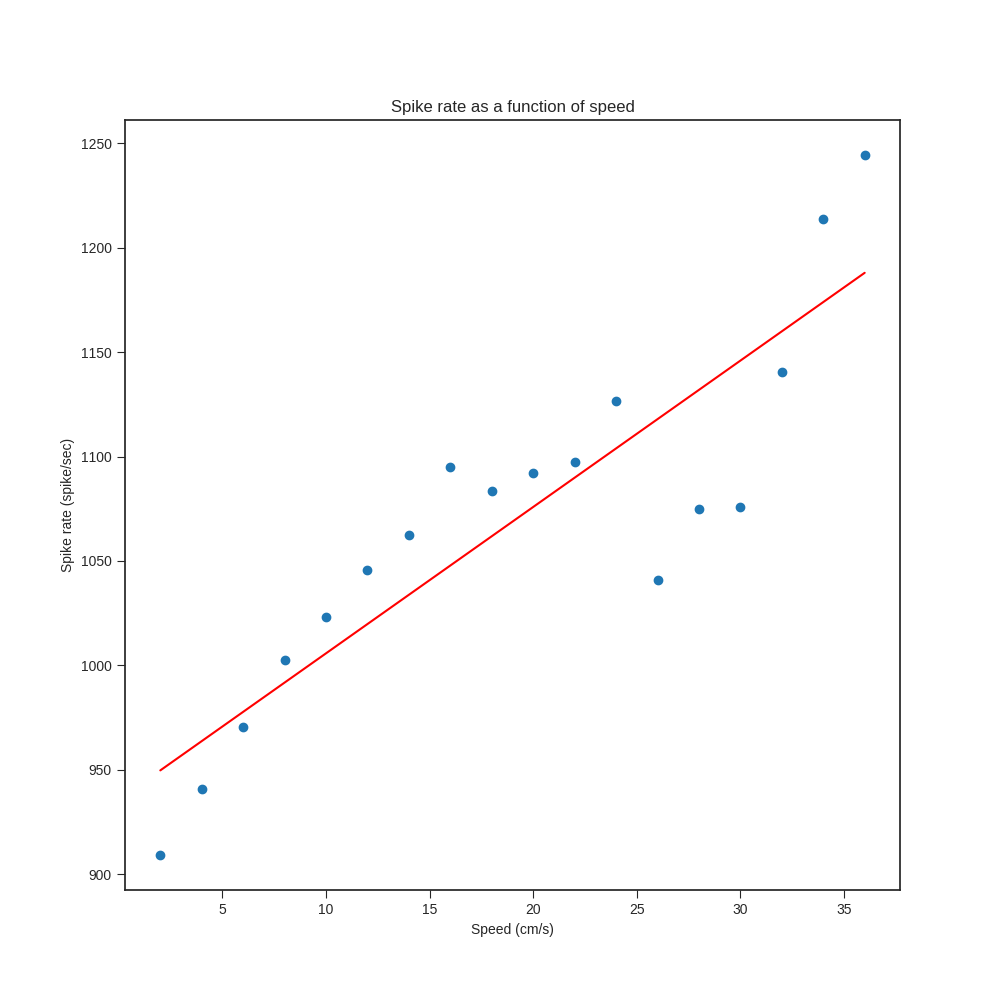

In [96]:
spike_rate = dt_value[:, 1] / dt_value[:, 0]
spike_rate = spike_rate[~np.isnan(spike_rate)]
vel_bins = [2,4,6,8,10,12,14,16,18,20]
x = vel_bins
# plt.plot(x, spike_rate, 'o' , color = 'deepskyblue')

from sklearn.linear_model import LinearRegression
x = np.array([vel_bins]).reshape((-1, 1))
y = spike_rate
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
y_pred = model.predict(x)
# print('coefficient of determination:', r_sq)
# print('intercept:', model.intercept_)
# print('slope:', model.coef_)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Spike rate (spike/sec)")
plt.title("Spike rate as a function of speed")
plt.savefig("Spike count as a function of speed (linear track).png")
plt.show()

In [103]:
print(x)
print(y)
print(len(x))
print(len(y))
print(y.shape)
print(spike_rate)

[[ 2]
 [ 4]
 [ 6]
 [ 8]
 [10]
 [12]
 [14]
 [16]
 [18]
 [20]
 [22]
 [24]
 [26]
 [28]
 [30]
 [32]
 [34]
 [36]]
[[ 909.23218993  940.93972548  970.28785887 1002.46156677 1023.10296023
  1045.67767038 1062.28021198 1095.11297592 1083.57109344 1092.26353757
  1097.51884428 1126.58963935 1041.01635023 1074.77500154 1075.92049084
  1140.44155895 1213.69960594 1244.35239392]]
18
1
(1, 18)
[ 909.23218993  940.93972548  970.28785887 1002.46156677 1023.10296023
 1045.67767038 1062.28021198 1095.11297592 1083.57109344 1092.26353757
 1097.51884428 1126.58963935 1041.01635023 1074.77500154 1075.92049084
 1140.44155895 1213.69960594 1244.35239392]
